
Muturretik muturrerako solasaldi sistema
===================================

Notebook honetan (https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html) oinarrituta, muturretik muturrerako solasaldi sistema bat entrenatzeko kodea topatuko duzu. 

Muturretik muturrerako sistema hau Neural machine translation by jointly learning to align and translate (Bahdanau, D., Cho, K., & Bengio, Y. (2014)) artikuluan proposatutako sisteman oinarritzen da eta solsaldia itzulpen automatikoko ataza bat bezala proposatzen du. 

Oharra: Notebook hau hurrengo kodean oinarritzen da: https://github.com/spro/practical-pytorch


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/HP/Lana/dialbot"

/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/HP/Lana/dialbot


https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb

https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb

## Preprocess Text

In [3]:
def get_text(filename, lines):
    with open(filename) as f:
        text = f.readlines()[:lines+1]
    return text

In [4]:
def clean_text(lines):
    clean = []
    for line in lines:
        clean.append(clean_line(line))
    return clean

In [5]:
def clean_line(t):
    t = t.replace('-', '')
    t = t.replace('\"', '')
    t = t.replace('\'', '')
    t = t.lower()
    return t

In [6]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def tokenize_text(text):
    tokenized_text = []
    for line in text:
        if line != "\n":
            tokens = word_tokenize(line)
            tokens_text = ' '.join(tokens)
            tokenized_text.append(tokens_text)
    return tokenized_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
def get_dialogs(text):
    dialogs = []
    for i, line in enumerate(text[1:]):
        dialog = text[i] + "\t" + text[i+1]
        dialogs.append(dialog)
    return dialogs

In [8]:
def save_text(filename, lines):
    with open(filename, 'w') as f:
        for line in lines:
            f.write(line + "\n")  

In [23]:
filename = "./data/eu.txt"
text = get_text(filename, 150000)
text[:10]

['Hauxe idatzita dago...\n',
 'Hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean:\n',
 '...naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean.\n',
 'Hau ere esana dago harrezkero:\n',
 '"Antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak, alegia.\n',
 'Gizakia beti egon da izaki horien beldurrez.\n',
 'Sorginkeria eta gaizkiaren gurtza existitzen dira gure egunetan ere.\n',
 'DEABRUAREN GAUA\n',
 'Hamabost.\n',
 'Bi gehi hiru berdin bost.\n']

In [24]:
text = clean_text(text)
text[:10]

['hauxe idatzita dago...\n',
 'hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean:\n',
 '...naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean.\n',
 'hau ere esana dago harrezkero:\n',
 'antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak, alegia.\n',
 'gizakia beti egon da izaki horien beldurrez.\n',
 'sorginkeria eta gaizkiaren gurtza existitzen dira gure egunetan ere.\n',
 'deabruaren gaua\n',
 'hamabost.\n',
 'bi gehi hiru berdin bost.\n']

In [25]:
text = tokenize_text(text)
text[:10]

['hauxe idatzita dago ...',
 'hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean :',
 '... naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean .',
 'hau ere esana dago harrezkero :',
 'antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak , alegia .',
 'gizakia beti egon da izaki horien beldurrez .',
 'sorginkeria eta gaizkiaren gurtza existitzen dira gure egunetan ere .',
 'deabruaren gaua',
 'hamabost .',
 'bi gehi hiru berdin bost .']

In [26]:
text = get_dialogs(text)
text[:10]

['hauxe idatzita dago ...\thauxe idatzita dago hasierako garaietatik harri zahar hauen gainean :',
 'hauxe idatzita dago hasierako garaietatik harri zahar hauen gainean :\t... naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean .',
 '... naturaz gaindiko izaki gaiztoak existitzen direla itzalen mundu batean .\thau ere esana dago harrezkero :',
 'hau ere esana dago harrezkero :\tantzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak , alegia .',
 'antzinako karaktere errunikoen ahalmen magikoa erabiltzen duen gizonak ilunpeko ahalmen horiek inbokatu ditzake infernuko deabruak , alegia .\tgizakia beti egon da izaki horien beldurrez .',
 'gizakia beti egon da izaki horien beldurrez .\tsorginkeria eta gaizkiaren gurtza existitzen dira gure egunetan ere .',
 'sorginkeria eta gaizkiaren gurtza existitzen dira gure egunetan ere .\tdeabruaren gaua',
 'deabruaren gaua\thamabost .',
 'hamabost .\tbi ge

In [27]:
filename = "./data/eu.tsv"
save_text(filename, text)

## Vocabulary

Sortu hiztegia BPE algoritmoa erabiliz (Sennrich et al., 2015).  Defektuz 10000 subtoken definituko ditugu. 


*Sennrich, R., Haddow, B., & Birch, A. (2015). Neural machine translation of rare words with subword units. arXiv preprint arXiv:1508.07909.(https://arxiv.org/abs/1508.07909). 



In [14]:
!pip install tokenizers
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

def train_tokenizer(input_path, output_path, vocab_size=10000):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(files=[input_path], vocab_size=vocab_size, special_tokens=["[PAD]", "<s>", "</s>", "<unk>"])
    tokenizer._tokenizer.post_processor = BertProcessing(
        ("</s>", tokenizer.token_to_id("</s>")),
        ("<s>", tokenizer.token_to_id("<s>")),
    )
    tokenizer.save_model(output_path)
    return tokenizer

def get_tokenizer(path):
    tokenizer = ByteLevelBPETokenizer(path + 'vocab.json', path + 'merges.txt')
    tokenizer._tokenizer.post_processor = BertProcessing(
        ("</s>", tokenizer.token_to_id("</s>")),
        ("<s>", tokenizer.token_to_id("<s>")),
    )
    return tokenizer

     |████████████████████████████████| 3.2MB 5.2MB/s 


In [28]:
tokenizer_eu = train_tokenizer('./data/eu.tsv', './model/eu/')

In [ ]:
tokenizer_en = train_tokenizer('./data/en_train.tsv', './model/en/')

## Dialog Dataset

Lehenik gure datuekin dataseta sortuko dugu 


In [16]:
from torch.utils.data import Dataset

class DialogDataset(Dataset):

    def __init__(self, dataset_path, tokenizer):

        self.tokenizer = tokenizer

        self.examples = [(self.tokenizer.encode(line.strip().split('\t')[0]).ids, \
                          self.tokenizer.encode(line.strip().split('\t')[1]).ids) \
                         for line in open(dataset_path, 'r', encoding='utf-8').readlines()]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i][0]), torch.tensor(self.examples[i][1])

In [17]:
from torch.utils.data import RandomSampler, DataLoader, random_split
import torch.nn as nn

BATCH_SIZE = 64
MAX_LENGTH = 50

def generate_batch(data_batch):
    src_batch, trg_batch = [], []
    for example in data_batch:
        src_batch.append(example[0][:MAX_LENGTH])
        trg_batch.append(example[1][:MAX_LENGTH])
    return nn.utils.rnn.pad_sequence(src_batch, tokenizer_eu.token_to_id('[PAD]')), \
        nn.utils.rnn.pad_sequence(trg_batch, tokenizer_eu.token_to_id('[PAD]'))

def get_dataloaders(filename, tokenizer):
    dataset = DialogDataset(filename, tokenizer)
    
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = int(0.1 * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_sampler = RandomSampler(train_dataset)
    val_sampler = RandomSampler(val_dataset)
    test_sampler = RandomSampler(test_dataset)
    
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE, collate_fn=generate_batch)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders('./data/en_train.tsv', tokenizer_en)

In [29]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders('./data/eu.tsv', tokenizer_eu)

## Model

Muturretik muturrerako sistema hau  Neural machine translation by jointly learning to align and translate (Bahdanau, D., Cho, K., & Bengio, Y. (2014)) artikuluan proposatutako sisteman oinarritzen da. Hau itzulpen automatikoko sistema bat da, beraz, dialogoa itzulpen automatikoko ataza bat bezala definitzen ari gara. Aukera hau ez da optimoa sinplifikazio handi bat baita, hala ere, esperimentu interesgarriak egiteko aukera ematen digu.



In [19]:
import random
from typing import Tuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor


class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: Tensor) -> Tuple[Tensor]:

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden


class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        src_len = encoder_outputs.shape[0]

        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(energy, dim=2)

        return F.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:

        a = self.attention(decoder_hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep, a


    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tuple[Tensor]:

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        weighted_encoder_rep, a = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)

        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        return output, decoder_hidden.squeeze(0), a.squeeze(1)


class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,
                src: Tensor,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:

        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        # first input to the decoder is the <sos> token
        output = trg[0,:]
        for t in range(1, max_len):
            output, hidden, _ = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs

In [30]:
#Tamainak egokitu zuen beharretara
INPUT_DIM = 10000
OUTPUT_DIM = 10000
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
ENC_HID_DIM = 1024
DEC_HID_DIM = 1024
ATTN_DIM = 1024
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
"""ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ATTN_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)


def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

optimizer = optim.Adam(model.parameters())


def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

#Ignore the index of the padding
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_eu.token_to_id('[PAD]'))

The model has 71,800,592 trainable parameters


## Train



In [21]:
import math
import time
from tqdm import tqdm

def train(model: nn.Module,
          train_dataloader: DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0
    for iteration, (src, trg) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0, leave=True):

        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_dataloader)

def valid(model: nn.Module, 
             val_dataloader: DataLoader,
             criterion: nn.Module):
    
    model.eval()
    
    epoch_loss = 0
    with torch.no_grad():
        for iteration, (src, trg) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), position=0, leave=True):

            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(val_dataloader)

def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
N_EPOCHS = 10
CLIP = 5.0

train_loss_plot = []
valid_loss_plot = []
best_valid_loss = float('inf')
for epoch in tqdm(range(N_EPOCHS), position=0, leave=True):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = valid(model, val_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_loss_plot.append(train_loss)
    valid_loss_plot.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './model/eu/model.pt')
    else:
        torch.save(model.state_dict(), './model/eu/model.pt')

    print(f'\nEpoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'Valid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}')

  0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 01 | Time: 23m 45s
Train Loss: 5.979 | Train PPL: 394.875
Valid Loss: 6.383 | Valid PPL: 591.457


  0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 02 | Time: 23m 47s
Train Loss: 5.538 | Train PPL: 254.096
Valid Loss: 6.345 | Valid PPL: 569.568


  0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 03 | Time: 23m 38s
Train Loss: 5.318 | Train PPL: 203.943
Valid Loss: 6.264 | Valid PPL: 525.238


  0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 04 | Time: 23m 47s
Train Loss: 5.126 | Train PPL: 168.346
Valid Loss: 6.260 | Valid PPL: 523.265


  0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 05 | Time: 23m 40s
Train Loss: 4.937 | Train PPL: 139.338
Valid Loss: 6.307 | Valid PPL: 548.525


  0%|          | 0/1875 [00:00<?, ?it/s]


Epoch: 06 | Time: 23m 49s
Train Loss: 4.709 | Train PPL: 110.997
Valid Loss: 6.440 | Valid PPL: 626.286


  1%|          | 12/1875 [00:09<27:01,  1.15it/s]

KeyboardInterrupt: ignored

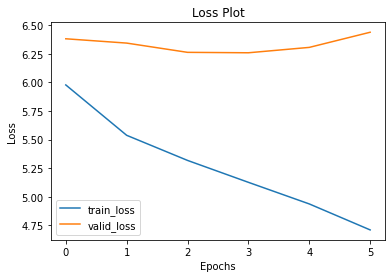

In [33]:
import matplotlib.pyplot as plt
plt.plot(train_loss_plot, label='train_loss')
plt.plot(valid_loss_plot, label='valid_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Test

In [ ]:
#Load model
model.load_state_dict(torch.load('./model/eu/model.pt', map_location=device))

tokenizer = get_tokenizer('./model/eu/')

In [ ]:
test_loss = valid(model, test_dataloader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

100%|██████████| 174/174 [00:37<00:00,  4.62it/s]


Test Loss: 1.675 | Test PPL:   5.338


## Inference

In [34]:
import torch
import random
from argparse import ArgumentParser

def decode(logits, decoding_strategy='max', k=3, temp=0.4):
    tokenizer.decode(logits.topk(10)[1][0].numpy())
    if decoding_strategy=='top1':
        target = logits.max(1)[1]
    elif decoding_strategy=='topk':
        target = logits.topk(k)[1][0][random.randint(0, k-1)].unsqueeze(-1)
    else:
        target = torch.multinomial(logits.squeeze().div(temp).exp().cpu(), 1)
    return target

def evaluate(sentence):
    with torch.no_grad():
        target = torch.Tensor([tokenizer.token_to_id('<s>')]).long()
        output_sentence = []
        encoder_outputs, hidden = model.encoder(torch.Tensor(tokenizer.encode(sentence).ids).long().unsqueeze(-1))
        # attentions = torch.zeros(MAX_LENGTH, 1, len(tokenizer.encode(sentence).ids)).to(device)
        for t in range(MAX_LENGTH):
            # first input to the decoder is the <sos> token
            output, hidden, attention = model.decoder(target, hidden, encoder_outputs)
            # attentions[i] = attention
            target = decode(output, decoding_strategy)
            if target.numpy() == tokenizer.token_to_id('</s>'):
                return tokenizer.decode(output_sentence)
            else:
                output_sentence.append(target.numpy()[0])
    return tokenizer.decode(output_sentence)

In [35]:
#Load model
device = 'cpu'
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)
model.load_state_dict(torch.load('./model/eu/model.pt', map_location=device))

tokenizer = get_tokenizer('./model/eu/')

In [36]:
MAX_LENGTH = 30

#Print welcome message
print('-------------------------------')
print('Welcome to the Chit Chat system')
print("Write 'Bye' to end the system.")
print('-------------------------------')

#Main system loop
user = input('-')
model.eval()
decoding_strategy = "top1" # choices=['top1', 'topk', 'multinomial']

while user != 'Bye' and user != 'Agur':
    sentence = evaluate(user)
    print('+' + sentence.capitalize())
    user = input('-')
    
sentence = evaluate(user)
print('+' + sentence.capitalize())

-------------------------------
Welcome to the Chit Chat system
Write 'Bye' to end the system.
-------------------------------
-kaixo
+Zer nahi duzu ?
-zuk ondo funtzionatzea
+Baina , margeita ,
-ez dizut ulertzen
+Zer ez , ez , ez .
-bai bai bai
+Zer da
-bot bat
+Zer ?
-chatbot bat
+Zer .
-Agur
+Horrelakorik ez da zentzugabeak erabili dituzte .
